In [1]:
import os
import h5py
import numba
import numpy as np
import pandas as pd
import scipy.integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from hoki.utils.exceptions import HokiFormatError
from pylab import cm
from scipy.optimize import fminbound
import matplotlib.ticker as ticker

In [2]:
data = h5py.File(f"/Users/dillon/Desktop/data.h5", "r")
observations = data['observations']

obs_Ia = observations['Ia']
obs_CCSN = observations['CCSN']
obs_LGRB = observations['LGRB']
obs_PISN = observations['PISN']

In [3]:
event_rates = data['event_rates']
h = event_rates.attrs['h']

In [4]:
desktop_path = '/Users/dillon/Desktop/'

In [5]:
BPASS_files = ['100_100', '100_300', '135_100', '135_300', '135all_100', '170_100', '170_300']
models = ['empmodel', 'harikane22', 'MD', 'TNG', 'EAGLE', 'millimillennium']

In [6]:
events = ['Ia_rates', 'CCSN_rates', 'LGRB_rates', 'PISN_rates']

In [7]:
bpass_file_colors = {
    '100_100': 'red',
    '100_300': 'blue',
    '135_100': 'green',
    '135_300': 'orange',
    '135all_100': 'purple',
    '170_100': 'brown',
    '170_300': 'pink',
}

obs_colors = {
    'Ia': 'grey',
    'CCSN': 'grey',
    'LGRB': 'grey',
    'PISN': 'grey',
}

In [8]:
model_data = {}

for model in models:
    model_data[model] = {}  
    for bpass_file in BPASS_files:
        folder_path = os.path.join(desktop_path, bpass_file)
        file_name = f"{model}_{bpass_file}.h5"
        file_path = os.path.join(folder_path, file_name)

        if os.path.exists(file_path):
            with h5py.File(file_path, 'r') as file:
                model_data[model][bpass_file] = {key: file[key][:] for key in file.keys()}

In [9]:
Ia_rates = {}
CCSN_rates = {}
LGRB_rates = {}
PISN_rates = {}

for model in models:
    Ia_rates[model] = {}  
    CCSN_rates[model] = {}  
    LGRB_rates[model] = {}  
    PISN_rates[model] = {}  

    for bpass_file in BPASS_files:
        folder_path = os.path.join(desktop_path, bpass_file)
        file_name = f"{model}_{bpass_file}.h5"
        file_path = os.path.join(folder_path, file_name)

        if os.path.exists(file_path):
            with h5py.File(file_path, 'r') as file:
                Ia_rates[model][bpass_file] = file['Ia_rates'][:]
                CCSN_rates[model][bpass_file] = file['CCSN_rates'][:]
                LGRB_rates[model][bpass_file] = file['LGRB_rates'][:]
                PISN_rates[model][bpass_file] = file['PISN_rates'][:]

### Empirical Model

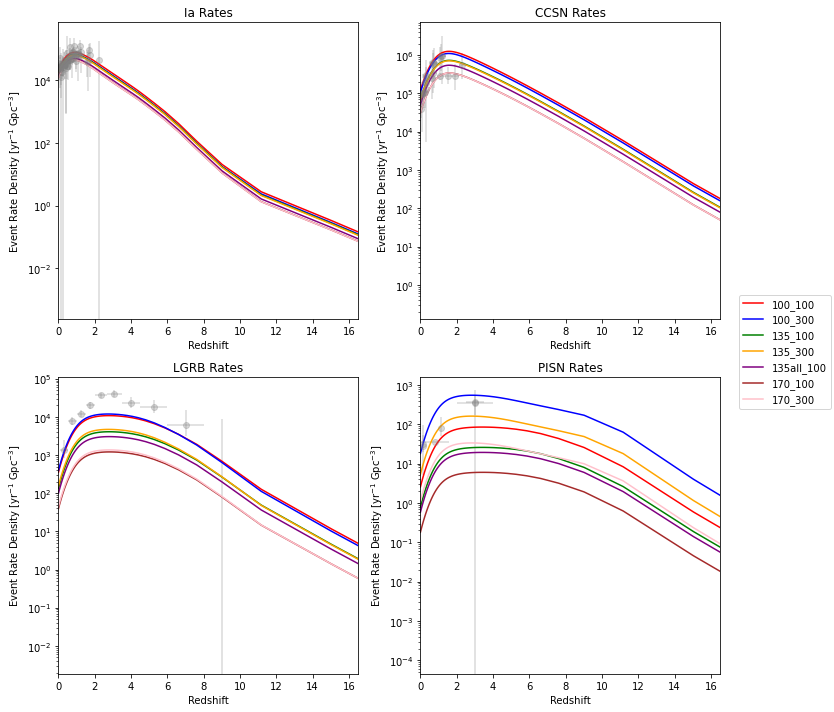

In [10]:
models_to_plot = ['empmodel']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        for bpass_file in BPASS_files:
            rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
            x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]
            
            line, = ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])
            
            if i == 0: 
                handles.append(line)
                labels.append(f'{bpass_file}')

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])  
    

    plt.show()

### Harikane 22

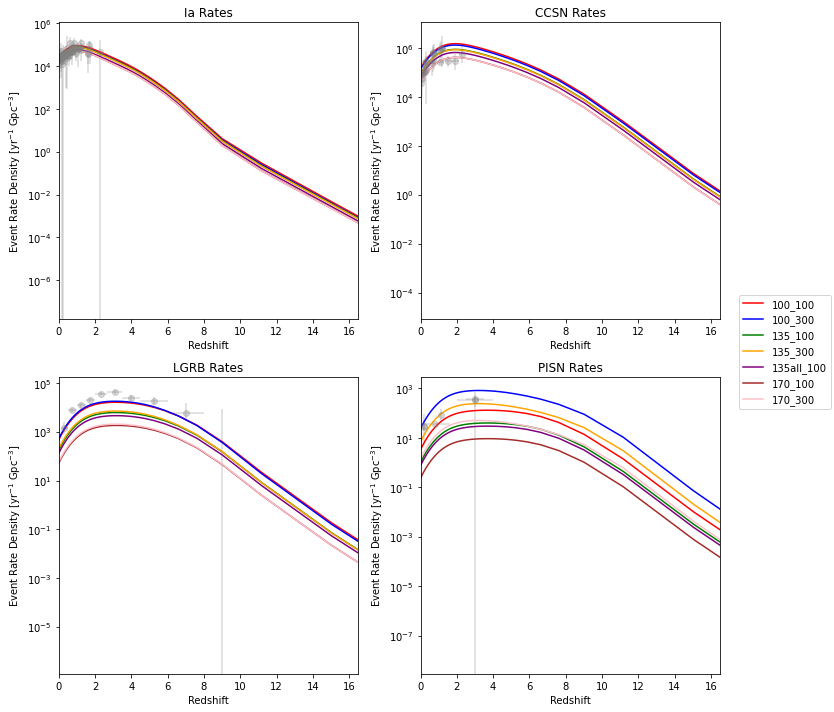

In [11]:
models_to_plot = ['harikane22']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        for bpass_file in BPASS_files:
            rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
            x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]
            
            line, = ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])
            
            if i == 0: 
                handles.append(line)
                labels.append(f'{bpass_file}')

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])  
    

    plt.show()

### TNG

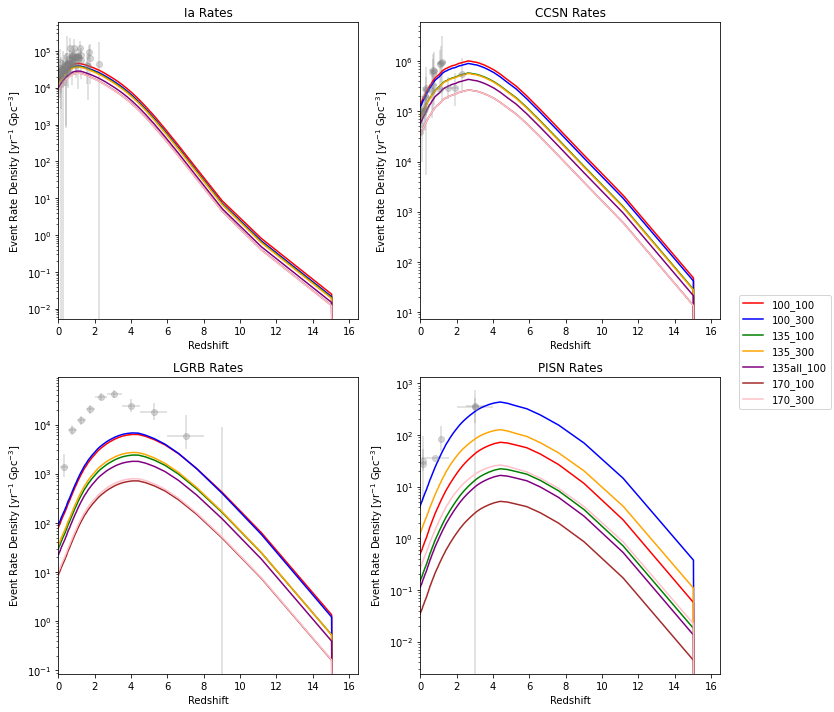

In [12]:
models_to_plot = ['TNG']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        for bpass_file in BPASS_files:
            rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
            x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]
            
            line, = ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])
            
            if i == 0: 
                handles.append(line)
                labels.append(f'{bpass_file}')

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])  
    

    plt.show()

### Madau & Dickinson 

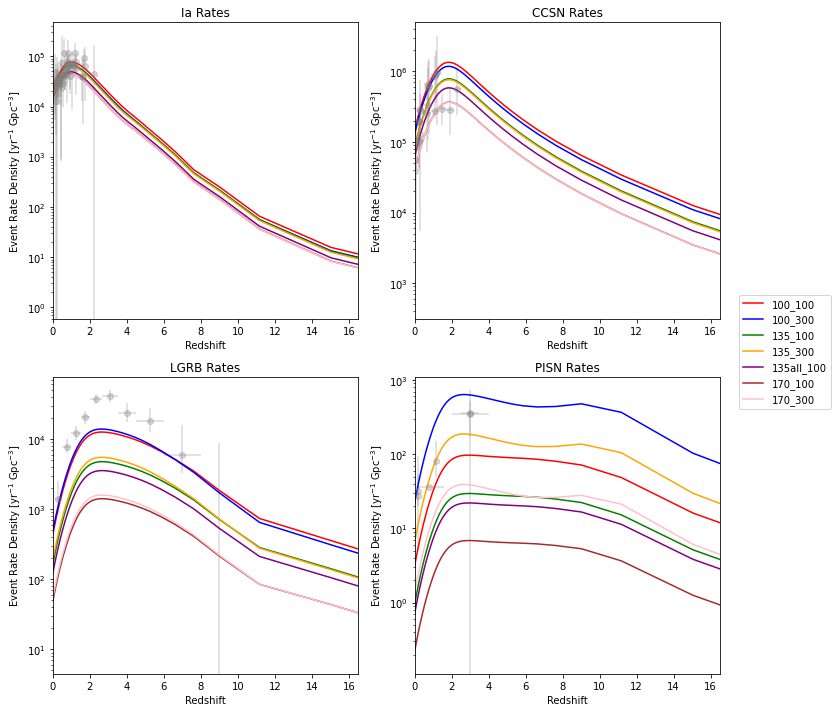

In [13]:
models_to_plot = ['MD']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        for bpass_file in BPASS_files:
            rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
            x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]
            
            line, = ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])
            
            if i == 0: 
                handles.append(line)
                labels.append(f'{bpass_file}')

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])  
    

    plt.show()

### EAGLE

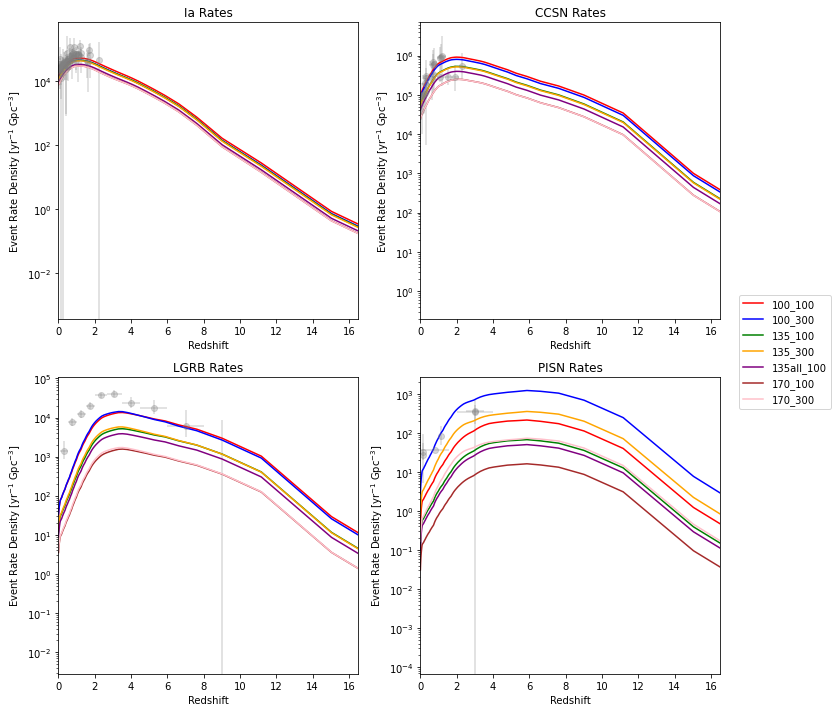

In [14]:
models_to_plot = ['EAGLE']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        for bpass_file in BPASS_files:
            rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
            x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]
            
            line, = ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])
            
            if i == 0: 
                handles.append(line)
                labels.append(f'{bpass_file}')

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])  
    

    plt.show()

### Millimillennium

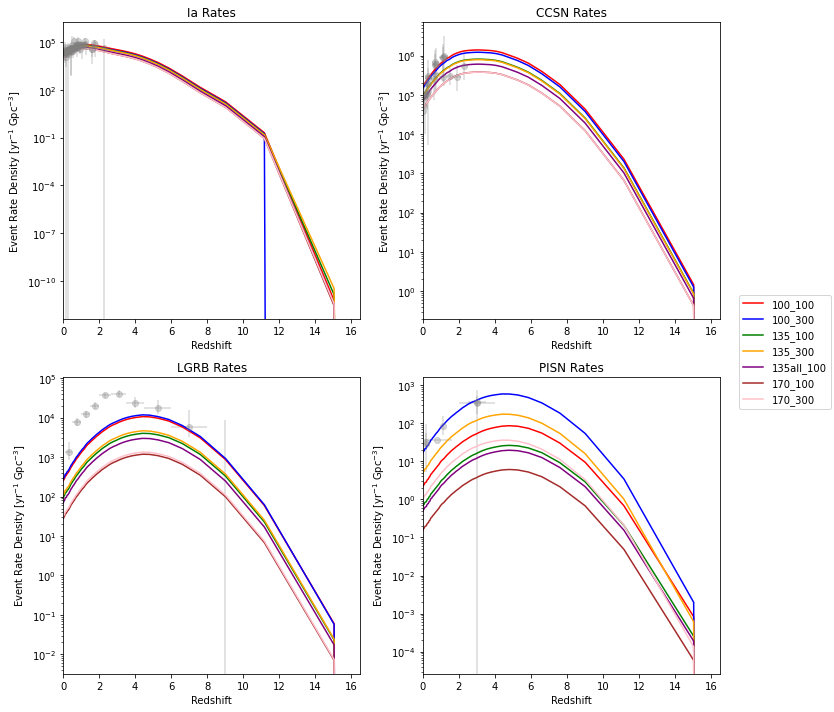

In [15]:
models_to_plot = ['millimillennium']

for model in models_to_plot:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    handles, labels = [], []

    for i, event_type in enumerate(['Ia', 'CCSN', 'LGRB', 'PISN']):
        ax = axs[i // 2, i % 2]

        title_position = 1
        ax.set_title(f'{event_type} Rates', y=title_position)

        for bpass_file in BPASS_files:
            rates_data = globals()[f'{event_type}_rates'][model][bpass_file]
            x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]
            
            line, = ax.plot(x_axis_data, rates_data, label=f'{bpass_file}', color=bpass_file_colors[bpass_file])
            
            if i == 0: 
                handles.append(line)
                labels.append(f'{bpass_file}')

        ax.errorbar(
            np.array(globals()[f'obs_{event_type}']['mean_z']),
            np.array(globals()[f'obs_{event_type}']['rate']) * h**3,
            xerr=[globals()[f'obs_{event_type}']['lower_z'], globals()[f'obs_{event_type}']['upper_z']],
            yerr=[globals()[f'obs_{event_type}']['lower_rate'] * h**3, globals()[f'obs_{event_type}']['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color=obs_colors[event_type],
        )

        ax.set_xlabel('Redshift')
        ax.set_ylabel(r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}]$")

        ax.set_yscale('log')
        ax.set_xlim(0, 16.5)

    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))
    plt.tight_layout(rect=[0, 0, 0.85, 1])  
    

    plt.show()

# Chi-Squared

In [16]:
Ia_out_Z = np.array(obs_Ia['mean_z'])
Ia_out_rate = obs_Ia['rate']
Ia_out_ylower = obs_Ia['lower_rate']
Ia_out_yupper = obs_Ia['upper_rate']

In [17]:
CCSN_out_Z = np.array(obs_CCSN['mean_z'])
CCSN_out_rate = obs_CCSN['rate']
CCSN_out_ylower = obs_CCSN['lower_rate']
CCSN_out_yupper = obs_CCSN['upper_rate']

In [20]:
#Note that as in the Briel paper the rate from Zhao, Xue & Cao is left out
PISN_out_Z = [0.17, 0.17, 1.13, 3.  , 3.]
PISN_out_rate =  [102.041 ,   89.4077,    265.306 , 1117.6   , 1166.18 ]
PISN_out_ylower = [37.9009,   72.6438,      104.956 ,  558.798 , 1166.18]
PISN_out_yupper = [72.8863,  215.137 ,     221.574 ,  558.798 , 1166.18]

In [68]:
def calculate_chi2(model, event_type, bpass_file, obs_Z, obs_rate, obs_ylower, obs_yupper, redshift_edges, h):
    r_model = model_data[model][bpass_file][f'{event_type}_rates']
    obs_rate = np.array(obs_rate)  
    obs_ylower = np.array(obs_ylower)  
    obs_yupper = np.array(obs_yupper)  
    chi = 0
    for obs_z, out_r, ylower, yupper in zip(obs_Z, obs_rate * h**3, obs_ylower * h**3, obs_yupper * h**3):
        pred = np.interp([obs_z], redshift_edges[:-1], r_model)
        sigma = max(ylower, yupper)
        chi += ((out_r - pred) / sigma)**2
    return chi[0] / len(obs_rate)

model_labels = {
    'empmodel': 'Empirical Model',
    'harikane22': 'Harikane 22',
    'MD': 'Madau & Dickinson',
    'millimillennium': 'Millimillennium',
    'EAGLE': 'EAGLE',
    'TNG': 'TNG',
}

models_to_plot = list(model_labels.keys())

for bpass_file in BPASS_files:
    print(f"\nResults for {bpass_file}:\n")
    for event_type in ['Ia', 'CCSN', 'PISN']:
        print(f'{event_type}:')
        for model in models_to_plot:
            obs_Z = np.array(globals()[f'{event_type}_out_Z'])
            obs_rate = globals()[f'{event_type}_out_rate']
            obs_ylower = globals()[f'{event_type}_out_ylower']
            obs_yupper = globals()[f'{event_type}_out_yupper']

            chi_squared = calculate_chi2(model, event_type, bpass_file, obs_Z, obs_rate, obs_ylower, obs_yupper, model_data[model][bpass_file]['redshift_edges'], h)
            print(f"  {model_labels[model]}: {chi_squared}")



Results for 100_100:

Ia:
  Empirical Model: 1.067308036988108
  Harikane 22: 1.6629773214591552
  Madau & Dickinson: 0.7199968737092542
  Millimillennium: 0.26292215757491133
  EAGLE: 0.38331765983291394
  TNG: 0.43935433500055143
CCSN:
  Empirical Model: 8.585371458190421
  Harikane 22: 13.177807008655659
  Madau & Dickinson: 9.439605057678921
  Millimillennium: 8.531612333658769
  EAGLE: 2.476909638133227
  TNG: 4.356873672552356
PISN:
  Empirical Model: 0.938509554824679
  Harikane 22: 0.7462676379814681
  Madau & Dickinson: 0.8957329018558422
  Millimillennium: 1.2861458571348816
  EAGLE: 1.013595370243611
  TNG: 1.4265560329283826

Results for 100_300:

Ia:
  Empirical Model: 0.4799691136406571
  Harikane 22: 0.7179906958039212
  Madau & Dickinson: 0.32264088379947786
  Millimillennium: 0.23445848861784535
  EAGLE: 0.6787629140323649
  TNG: 0.7715587776320683
CCSN:
  Empirical Model: 5.7300685623985075
  Harikane 22: 9.02043898884638
  Madau & Dickinson: 6.329175557781266
  Mill

In [69]:
combined_chi_squared = {}  

for bpass_file in BPASS_files:
    combined_chi_squared[bpass_file] = {}  
    
    for model in models_to_plot:
        combined_chi_squared[bpass_file][model] = 0  
        
        for event_type in ['Ia', 'CCSN', 'PISN']:
            obs_Z = np.array(globals()[f'{event_type}_out_Z'])
            obs_rate = globals()[f'{event_type}_out_rate']
            obs_ylower = globals()[f'{event_type}_out_ylower']
            obs_yupper = globals()[f'{event_type}_out_yupper']

            chi_squared = calculate_chi2(model, event_type, bpass_file, obs_Z, obs_rate, obs_ylower, obs_yupper, model_data[model][bpass_file]['redshift_edges'], h)

            if event_type == 'Ia':
                combined_chi_squared[bpass_file][model] += chi_squared * 60
            elif event_type == 'CCSN':
                combined_chi_squared[bpass_file][model] += chi_squared * 25
            elif event_type == 'PISN':
                combined_chi_squared[bpass_file][model] += chi_squared * 5

        combined_chi_squared[bpass_file][model] /= 90

for bpass_file in BPASS_files:
    print(f"\nCombined Chi-squared values for {bpass_file}:\n")
    for model in models_to_plot:
        print(f"  {model_labels[model]}: {combined_chi_squared[bpass_file][model]}")



Combined Chi-squared values for 100_100:

  Empirical Model: 3.1485035160907824
  Harikane 22: 4.810612807709424
  Madau & Dickinson: 3.1518733708200837
  Millimillennium: 2.6166263009070923
  EAGLE: 0.9998864154947064
  TNG: 1.5823986897609321

Combined Chi-squared values for 100_300:

  Empirical Model: 2.047289551319498
  Harikane 22: 3.216774498132244
  Madau & Dickinson: 2.0946860359397577
  Millimillennium: 1.73193153915561
  EAGLE: 0.9652941772580952
  TNG: 1.3376499173764436

Combined Chi-squared values for 135_100:

  Empirical Model: 0.7367844535017108
  Harikane 22: 1.0844891269579198
  Madau & Dickinson: 0.6440400918771495
  Millimillennium: 0.5566427347365834
  EAGLE: 0.7304494426693561
  TNG: 0.8178739053178737

Combined Chi-squared values for 135_300:

  Empirical Model: 0.6065272450928892
  Harikane 22: 0.8766995453776544
  Madau & Dickinson: 0.5312866837817961
  Millimillennium: 0.5146208323447247
  EAGLE: 0.7487272453904753
  TNG: 0.8583482691481809

Combined Chi-squ